In [139]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer


In [140]:
df= pd.read_csv(r"D:\Projects\My_Estate_Project\data\raw\gurgaon_properties_cleaned_v1.csv")

In [141]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [142]:
df.head(2)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,ss the leaf,sector 85,1.25,10888.0,1148.0,Super Built up area 1741(161.74 sq.m.)Carpet area: 1148 sq.ft. (106.65 sq.m.),2,2,3+,store room,17.0,East,1 to 5 Year Old,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Central Peripheral Road', 'NH 08', 'Pataudi Road', 'Delhi Public School Sector 84', 'DPG Institute of Technology', 'Genesis Hospital Sector 84', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'SkyJumper Trampoline Park', 'Nakhrola Stadium Sector 81A']","['1 Exhaust Fan', '10 Light', '4 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
1,flat,chd avenue,sector 71,1.40,7945.0,1762.0,Carpet area: 1762 (163.7 sq.m.),3,3,2,pooja room,1.0,South-East,5 to 10 Year Old,"['Huda City Centre', 'Apna Mart', 'Rajiv Chowk', 'Sohna Road', 'IFFCO Chowk', 'Medanta Hospital', 'Max Hospital, Gurugram', 'IGI Airport', 'HDFC Bank', 'Candor Park', 'Marriott Courtyard', 'Radisson Suites', 'Park Plaza', 'Flipkart Warehouse', 'Sadar Police Station']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '1 Geyser', '50 Light', '1 Chimney', '1 Curtains', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Spacious Interiors', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']"


### Feature Engineering on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

In [143]:
df.duplicated().sum()

122

In [144]:
df.drop_duplicates(inplace=True)

In [145]:
df.duplicated().sum()

0

In [146]:
df["areaWithType"].value_counts()

areaWithType
Plot area 360(301.01 sq.m.)                                                                                                     37
Plot area 300(250.84 sq.m.)                                                                                                     26
Plot area 502(419.74 sq.m.)                                                                                                     19
Plot area 200(167.23 sq.m.)                                                                                                     19
Plot area 270(225.75 sq.m.)                                                                                                     17
Super Built up area 1578(146.6 sq.m.)                                                                                           17
Super Built up area 1950(181.16 sq.m.)Carpet area: 1161 sq.ft. (107.86 sq.m.)                                                   17
Super Built up area 1350(125.42 sq.m.)                                

In [147]:
df.sample(5)[["area", "areaWithType"]]

,area,areaWithType
526,1568.0,Super Built up area 1568(145.67 sq.m.)
3118,2112.0,Super Built up area 1735(161.19 sq.m.)
2266,2050.0,Carpet area: 2050 (190.45 sq.m.)
1772,2289.0,Super Built up area 2289(212.66 sq.m.)Carpet area: 1121 sq.ft. (104.14 sq.m.)
1765,2267.0,Super Built up area 2115(196.49 sq.m.)


In [148]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [149]:
# This function extracts the Super built up area or Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [150]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [151]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [152]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1724,0.90,house,900.0,Plot area 100(83.61 sq.m.),NaN,NaN,NaN
3088,0.35,flat,576.0,Super Built up area 576(53.51 sq.m.)Carpet area: 480.53 sq.ft. (44.64 sq.m.),576.0,NaN,480.53
2513,1.02,flat,1283.0,Built Up area: 1283 (119.19 sq.m.)Carpet area: 734.43 sq.ft. (68.23 sq.m.),NaN,1283.0,734.43
935,1.25,flat,1620.0,Super Built up area 1620(150.5 sq.m.)Carpet area: 862.18 sq.ft. (80.1 sq.m.),1620.0,NaN,862.18
2869,0.86,flat,1428.0,Super Built up area 1430(132.85 sq.m.),1430.0,NaN,NaN


In [153]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(531, 7)

In [154]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
6,8.49,house,1800.0,Plot area 200(167.23 sq.m.),NaN,NaN,NaN
8,2.10,house,900.0,Plot area 100(83.61 sq.m.),NaN,NaN,NaN
16,NaN,house,NaN,Plot area 250(209.03 sq.m.)Built Up area: 260 sq.yards (217.39 sq.m.)Carpet area: 245 sq.yards (204.85 sq.m.),NaN,260.0,245.0
24,7.30,house,46795.0,Plot area 215(179.77 sq.m.)Built Up area: 5800 sq.yards (4849.54 sq.m.)Carpet area: 5200 sq.yards (4347.86 sq.m.),NaN,5800.0,5200.0
41,2.95,house,1449.0,Plot area 161(134.62 sq.m.)Built Up area: 1000 sq.yards (836.13 sq.m.),NaN,1000.0,NaN


In [155]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    17
Price_per_sqft           17
area                     17
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1048
agePossession             1
nearbyLocations         170
furnishDetails          946
features                599
super_built_up_area    1805
built_up_area          2534
carpet_area            1807
dtype: int64

In [156]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [157]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
6,8.49,house,1800.0,Plot area 200(167.23 sq.m.),NaN,NaN,NaN
8,2.10,house,900.0,Plot area 100(83.61 sq.m.),NaN,NaN,NaN
50,0.50,house,360.0,Plot area 40(33.45 sq.m.),NaN,NaN,NaN
54,1.00,house,126.0,Plot area 126(11.71 sq.m.),NaN,NaN,NaN
55,0.85,house,13492.0,Plot area 1500(1254.19 sq.m.),NaN,NaN,NaN


In [158]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [159]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [160]:
# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

In [161]:
all_nan_df.sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2608,5.88,house,2160.0,Plot area 240(200.67 sq.m.),NaN,240.0,NaN
1096,0.65,house,585.0,Plot area 65(54.35 sq.m.),NaN,65.0,NaN
50,0.50,house,360.0,Plot area 40(33.45 sq.m.),NaN,40.0,NaN
1807,10.85,house,2844.0,Plot area 316(264.22 sq.m.),NaN,316.0,NaN
3080,9.50,house,546.0,Plot area 546(50.73 sq.m.),NaN,546.0,NaN


In [162]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [163]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [164]:
all_nan_df.sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2152,0.58,house,67.0,Plot area 67(6.22 sq.m.),NaN,67.0,NaN
3363,6.00,house,2430.0,Plot area 270(225.75 sq.m.),NaN,2430.0,NaN
134,19.00,house,4500.0,Plot area 500(418.06 sq.m.),NaN,4500.0,NaN
360,3.65,house,3450.0,Plot area 3450(320.52 sq.m.),NaN,3450.0,NaN
3234,23.00,house,9000.0,Plot area 1000(836.13 sq.m.),NaN,9000.0,NaN


In [165]:
# update the original dataframe
df.update(all_nan_df)

In [166]:
df.head()

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,ss the leaf,sector 85,1.25,10888.0,1148.0,Super Built up area 1741(161.74 sq.m.)Carpet area: 1148 sq.ft. (106.65 sq.m.),2,2,3+,store room,17.0,East,1 to 5 Year Old,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Central Peripheral Road', 'NH 08', 'Pataudi Road', 'Delhi Public School Sector 84', 'DPG Institute of Technology', 'Genesis Hospital Sector 84', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'SkyJumper Trampoline Park', 'Nakhrola Stadium Sector 81A']","['1 Exhaust Fan', '10 Light', '4 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']",1741.0,NaN,1148.00
1,flat,chd avenue,sector 71,1.40,7945.0,1762.0,Carpet area: 1762 (163.7 sq.m.),3,3,2,pooja room,1.0,South-East,5 to 10 Year Old,"['Huda City Centre', 'Apna Mart', 'Rajiv Chowk', 'Sohna Road', 'IFFCO Chowk', 'Medanta Hospital', 'Max Hospital, Gurugram', 'IGI Airport', 'HDFC Bank', 'Candor Park', 'Marriott Courtyard', 'Radisson Suites', 'Park Plaza', 'Flipkart Warehouse', 'Sadar Police Station']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '1 Geyser', '50 Light', '1 Chimney', '1 Curtains', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Spacious Interiors', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']",NaN,NaN,1762.00
2,flat,smart world orchard,sector 61,1.47,12782.0,1150.0,Carpet area: 1150 (106.84 sq.m.),2,2,2,"pooja room,study room",4.0,North-East,Within 6 months,"['Sector 55-56 Metro station', 'Bestech Central Square Mall', 'Golf Course Ext Road', 'Badshahpur Sohna Rd Hwy', 'ORCHIDS The International School', 'Sushant University', 'Marengo Asia Hospitals', 'Indira Gandhi Intl Airport', 'Gurgaon Railway Station']",[],"['Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Swimming Pool', 'Park', 'Visitor Parking', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']",NaN,NaN,1150.00
3,flat,tarc maceo,sector 91,0.89,6339.0,1404.0,Super Built up area 1404(130.44 sq.m.)Carpet area: 1200 sq.ft. (111.48 sq.m.),2,2,3+,others,9.0,East,1 to 5 Year Old,"['Manish Gallexie 91', 'Dwarka Expressway', 'Rao Bharat Singh International School', 'Dronacharya College of Engineering', 'Silver Streak Multi Speciality Hospital', 'Indira Gandhi International Airport', 'IMT Manesar', 'Holiday Inn Sector 90', 'Manesar Golf Course', 'National Tennis Academy']","['2 Wardrobe', '5 Fan', '1 Exhaust Fan', '1 Geyser', '4 Light', '1 Chimney', '

### 2.additionalRoom

In [167]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1516
servant room                                      688
study room                                        243
others                                            219
pooja room                                        164
store room                                         97
study room,servant room                            97
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                55
pooja room,study room,servant room,others          54
pooja room,study room,servant room                 53
servant room,pooja room                            38
servant room,store room                            31
study room,others                                  26
pooja room,study room                              21
pooja room,others                                  16
pooja room,store room                              15
pooja room,st

In [168]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [169]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
3338,"study room,pooja room",1,0,0,1,0
3132,not available,0,0,0,0,0
1187,not available,0,0,0,0,0
1748,"study room,pooja room,servant room",1,1,0,1,0
2411,"servant room,study room",1,1,0,0,0


In [170]:
df.head(2)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,ss the leaf,sector 85,1.25,10888.0,1148.0,Super Built up area 1741(161.74 sq.m.)Carpet area: 1148 sq.ft. (106.65 sq.m.),2,2,3+,store room,17.0,East,1 to 5 Year Old,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Central Peripheral Road', 'NH 08', 'Pataudi Road', 'Delhi Public School Sector 84', 'DPG Institute of Technology', 'Genesis Hospital Sector 84', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'SkyJumper Trampoline Park', 'Nakhrola Stadium Sector 81A']","['1 Exhaust Fan', '10 Light', '4 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']",1741.0,NaN,1148.0,0,0,1,0,0
1,flat,chd avenue,sector 71,1.40,7945.0,1762.0,Carpet area: 1762 (163.7 sq.m.),3,3,2,pooja room,1.0,South-East,5 to 10 Year Old,"['Huda City Centre', 'Apna Mart', 'Rajiv Chowk', 'Sohna Road', 'IFFCO Chowk', 'Medanta Hospital', 'Max Hospital, Gurugram', 'IGI Airport', 'HDFC Bank', 'Candor Park', 'Marriott Courtyard', 'Radisson Suites', 'Park Plaza', 'Flipkart Warehouse', 'Sadar Police Station']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '1 Geyser', '50 Light', '1 Chimney', '1 Curtains', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Spacious Interiors', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']",NaN,NaN,1762.0,0,0,0,1,0


### 3. agePossession

In [171]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1646
5 to 10 Year Old       563
0 to 1 Year Old        503
undefined              307
10+ Year Old           303
Under Construction      88
Within 6 months         67
Within 3 months         24
Dec-23                  20
By 2023                 17
By 2024                 16
Dec-24                  15
Mar-24                  12
Jan-24                   7
Jun-24                   7
Dec-25                   7
Aug-23                   6
Oct-24                   6
Nov-23                   5
By 2025                  4
Oct-23                   4
Sep-23                   4
Aug-24                   4
May-24                   3
Feb-24                   3
Jul-24                   3
Nov-24                   3
Jan-25                   3
Jul-27                   2
Dec-26                   2
Jun-27                   2
Jul-25                   2
Apr-26                   2
Aug-25                   2
Mar-25                   2
Sep-25                   2
Jan-26        

In [172]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [173]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [174]:
df.head(2)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,ss the leaf,sector 85,1.25,10888.0,1148.0,Super Built up area 1741(161.74 sq.m.)Carpet area: 1148 sq.ft. (106.65 sq.m.),2,2,3+,store room,17.0,East,Relatively New,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Central Peripheral Road', 'NH 08', 'Pataudi Road', 'Delhi Public School Sector 84', 'DPG Institute of Technology', 'Genesis Hospital Sector 84', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'SkyJumper Trampoline Park', 'Nakhrola Stadium Sector 81A']","['1 Exhaust Fan', '10 Light', '4 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']",1741.0,NaN,1148.0,0,0,1,0,0
1,flat,chd avenue,sector 71,1.40,7945.0,1762.0,Carpet area: 1762 (163.7 sq.m.),3,3,2,pooja room,1.0,South-East,Moderately Old,"['Huda City Centre', 'Apna Mart', 'Rajiv Chowk', 'Sohna Road', 'IFFCO Chowk', 'Medanta Hospital', 'Max Hospital, Gurugram', 'IGI Airport', 'HDFC Bank', 'Candor Park', 'Marriott Courtyard', 'Radisson Suites', 'Park Plaza', 'Flipkart Warehouse', 'Sadar Police Station']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '1 Geyser', '50 Light', '1 Chimney', '1 Curtains', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Spacious Interiors', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']",NaN,NaN,1762.0,0,0,0,1,0


### 4.furnishDetails

In [175]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
3095,"['5 Wardrobe', '5 Fan', '1 Exhaust Fan', '4 Geyser', '1 Stove', '16 Light', '1 Chimney', '5 AC', '1 Modular Kitchen', '8 Curtains', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
1894,"['1 Water Purifier', '18 Fan', '1 Exhaust Fan', '15 Geyser', '1 Stove', '52 Light', '1 Chimney', '1 Curtains', '1 Modular Kitchen', '15 Wardrobe', '1 Microwave', 'No AC', 'No Bed', 'No Dining Table', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Security / Fire Alarm', 'Private Garden / Terrace', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting']"
1766,"['4 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
2032,"['10 Wardrobe', '10 Fan', '1 Exhaust Fan', '12 Geyser', '10 Light', '1 Modular Kitchen', '6 AC', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Park', 'Security Personnel', 'Low Density Society', 'Club house / Community Center']"
2516,"['1 Wardrobe', '1 Exhaust Fan', '6 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Lift(s)', 'Water Storage']"


In [176]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [177]:
furnishings_df.shape

(3681, 19)

In [178]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

C:\Users\syeds\AppData\Local\Temp\ipykernel_20540\114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [179]:
furnishings_df.sample(5)

,TV,Curtains,Exhaust Fan,AC,Stove,Fridge,Sofa,Dining Table,Modular Kitchen,Microwave,Fan,Geyser,Water Purifier,Washing Machine,Chimney,Light,Bed,Wardrobe
2507,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
608,0,0,1,0,0,0,0,0,1,0,3,3,0,0,0,10,0,2
1519,0,1,1,4,0,0,1,1,1,0,14,6,1,0,1,40,0,8


In [180]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [181]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

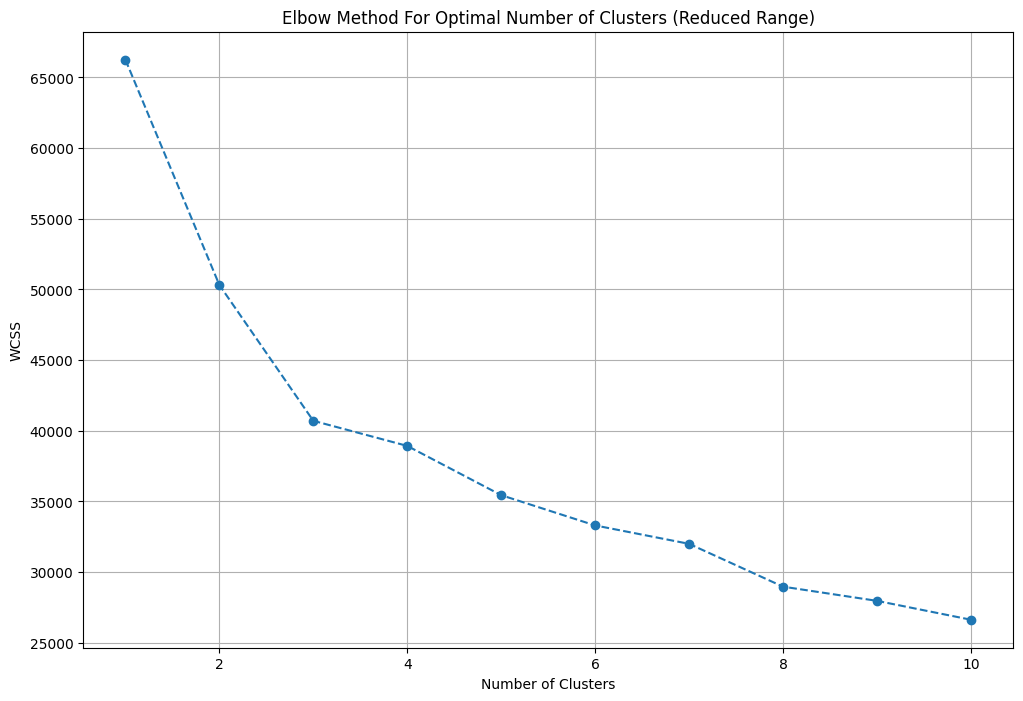

In [182]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [183]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [184]:
df = df.iloc[:,:-18]

In [185]:
df['furnishing_type'] = cluster_assignments

In [186]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
1226,[],0
2195,[],0
609,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0
3580,"['1 Wardrobe', '5 Fan', '1 Exhaust Fan', '21 Light', '1 Modular Kitchen', '1 Chimney', '6 AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",1
2724,"['3 Wardrobe', '5 Fan', '14 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",0


### 5.features

In [187]:
df[['society','features']].sample(5)

,society,features
2087,international city by sobha phase 1,"['Water purifier', 'Centrally Air Conditioned', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Fitness Centre / GYM', 'Club house / Community Center']"
1703,eldeco accolade,"['Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park']"
394,tulip violet,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
3154,independent,"['Feng Shui / Vaastu Compliant', 'Water Storage', 'Park', 'Waste Disposal', 'Rain Water Harvesting']"
3108,emaar mgf emerald floors premier,"['Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [188]:
df['features'].isnull().sum()

599

In [189]:
appartments_df = pd.read_csv(r'D:\Projects\My_Estate_Project\data\raw\appartments.csv')
appartments_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"


In [190]:
appartments_df['PropertyName'] = appartments_df['PropertyName'].str.lower()

In [191]:
temp_df = df[df['features'].isnull()]

In [192]:
temp_df.shape

(599, 26)

In [193]:
x = temp_df.merge(appartments_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [194]:
df.loc[temp_df.index,'features'] = x.values

In [195]:
df['features'].isnull().sum()

457

In [196]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [197]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2668,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0
115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1119,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0


In [198]:
features_binary_df.shape

(3681, 130)

In [199]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

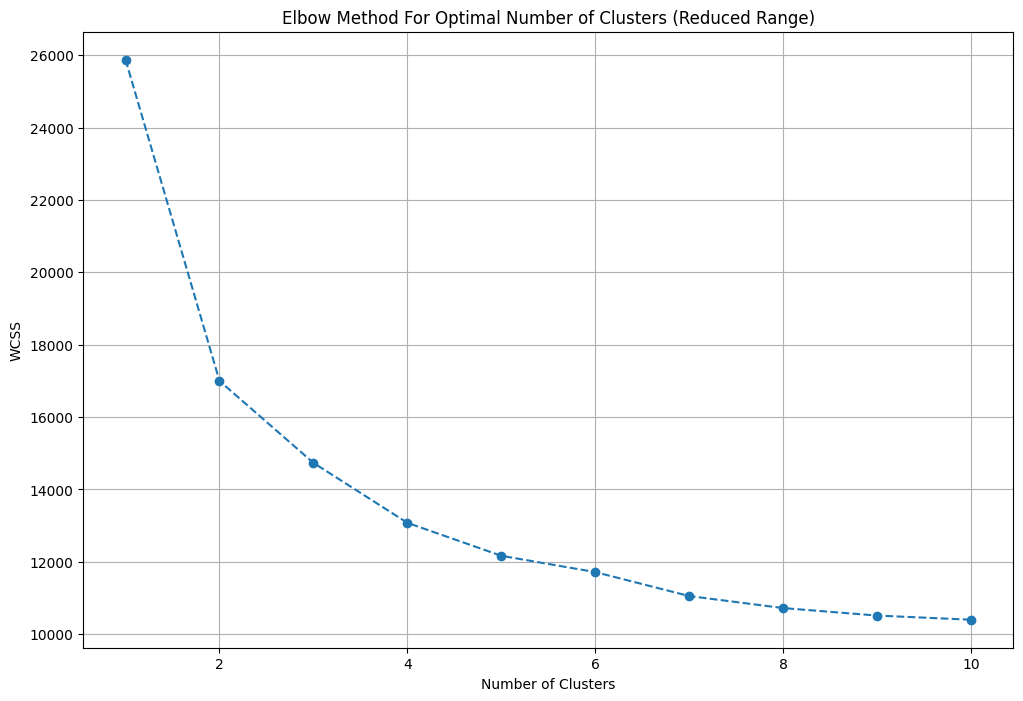

In [200]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [201]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [202]:
df['luxury_score'] = luxury_score

In [203]:
df.head(2)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,ss the leaf,sector 85,1.25,10888.0,1148.0,Super Built up area 1741(161.74 sq.m.)Carpet area: 1148 sq.ft. (106.65 sq.m.),2,2,3+,store room,17.0,East,Relatively New,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Central Peripheral Road', 'NH 08', 'Pataudi Road', 'Delhi Public School Sector 84', 'DPG Institute of Technology', 'Genesis Hospital Sector 84', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'SkyJumper Trampoline Park', 'Nakhrola Stadium Sector 81A']","['1 Exhaust Fan', '10 Light', '4 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']",1741.0,NaN,1148.0,0,0,1,0,0,0,"[Centrally Air Conditioned, Water purifier, Security / Fire Alarm, Feng Shui / Vaastu Compliant, Intercom Facility, Lift(s), High Ceiling Height, Maintenance Staff, False Ceiling Lighting, Water Storage, Separate entry for servant room, No open drainage around, Bank Attached Property, Piped-gas, Internet/wi-fi connectivity, Visitor Parking, Swimming Pool, Park, Security Personnel, Natural Light, Airy Rooms, Low Density Society, Waste Disposal, Rain Water Harvesting, Water softening plant, Shopping Centre, Fitness Centre / GYM, Club house / Community Center]",156.0
1,flat,chd avenue,sector 71,1.40,7945.0,1762.0,Carpet area: 1762 (163.7 sq.m.),3,3,2,pooja room,1.0,South-East,Moderately Old,"['Huda City Centre', 'Apna Mart', 'Rajiv Chowk', 'Sohna Road', 'IFFCO Chowk', 'Medanta Hospital', 'Max Hospital, Gurugram', 'IGI Airport', 'HDFC Bank', 'Candor Park', 'Marriott Courtyard', 'Radisson Suites', 'Park Plaza', 'Flipkart Warehouse', 'Sadar Police Station']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '1 Geyser', '50 Light', '1 Chimney', '1 Curtains', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Spacious Interiors', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']",NaN,NaN,1762.0,0,0,0,1,0,1,"[Security / Fire Alarm, Feng Shui / Vaastu Compliant, Intercom Facility, Lift(s), Maintenance Staff, False Ceiling Lighting, Water Storage, No open drainage around, Bank Attached Property, Recently Renovated, Piped-gas, Visitor Parking, Swimming Pool, Park, Security Personnel, Natural Light, Internet/wi-fi connectivity, Spacious Interiors, Low Density Society, Shopping Centre, Fitness Centre / GYM, Waste Disposal, Rain Water Harvesting, Club house / Community Center]",125.0


In [204]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [205]:
df.sample(5)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2457,house,sector 14 rwa,sector 14,5.51,16990.0,3243.0,Plot area 361(301.84 sq.m.),3,3,2,4.0,South-West,Moderately Old,NaN,3249.0,NaN,0,0,0,0,0,0,97.0
3248,house,independent,sector 38,3.50,24306.0,1440.0,Carpet area: 160 (133.78 sq.m.),3,3,2,1.0,East,Relatively New,NaN,NaN,160.0,0,0,0,0,0,0,35.0
16,house,independent,sector 25,NaN,NaN,NaN,Plot area 250(209.03 sq.m.)Built Up area: 260 sq.yards (217.39 sq.m.)Carpet area: 245 sq.yards (204.85 sq.m.),12,12,3+,4.0,North-East,New Property,NaN,260.0,245.0,1,1,0,1,1,2,144.0
630,flat,shree balaji appartment,sector 33,0.40,5000.0,800.0,Super Built up area 800(74.32 sq.m.),2,2,2,1.0,NaN,Relatively New,800.0,NaN,NaN,0,0,0,0,0,2,60.0
2245,flat,ss radiance residency,sector 12,0.60,5660.0,1060.0,Carpet area: 1060 (98.48 sq.m.),3,3,2,3.0,North-East,Relatively New,NaN,NaN,1060.0,0,0,0,0,0,0,55.0


In [206]:
df.shape

(3681, 23)

In [207]:
df.to_csv('D:/Projects/My_Estate_Project/data/raw/gurgaon_properties_cleaned_v2.csv',index=False)

: 